In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from HullWhite import HullWhite
from scipy.optimize import fsolve
beta = np.array([1.879892, 0.579211, 	3.993992, 1.445091])
tau  = np.array([ 16.633491, 	0.319680])
reversion=0.13949636660880768 
volatility=0.017793899652989272
# HW = HullWhite(initial=0.02459103, reversion=0.03, volatility=0.00200, Gamma=1000, b=beta, tau=tau)
HW = HullWhite(initial=0.02459103, reversion=reversion, volatility=volatility, Gamma=1000, b=beta, tau=tau)

 

In [8]:
from joblib import Parallel, delayed, cpu_count, dump, load
preSavedSims = []
dt=1/365
sims = np.power(10,1)
def worker(i):
        float = HW.create_path(dt,30, seed=i)[1]
        print('{:.2f}%'.format(round(i/sims*100, 2)), end='\r')
        return float


# results = Parallel(n_jobs=np.minimum(cpu_count(),sims))(delayed(worker)(i) for i in range(sims))


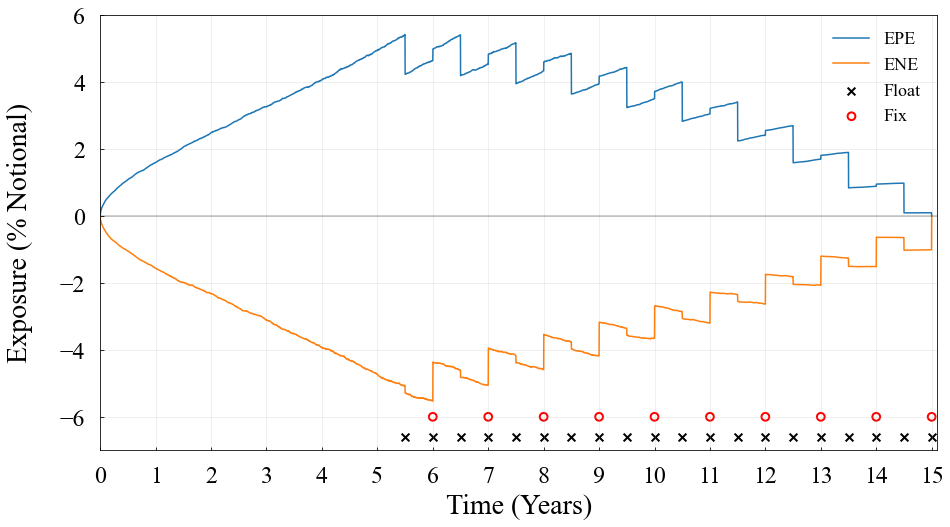

In [18]:
time, float = HW.create_path(dt,15, seed=0)
PE = load('SimulationData/PE_5Y10Y_ForwardSwap_N=5000_dt=365.joblib')
NE = load('SimulationData/NE_5Y10Y_ForwardSwap_N=5000_dt=365.joblib')
discounting = np.array([HW.marketZCB(t) for t in time])
plt.rc('font',family='Times New Roman')
float_x = np.arange(5.5,15.5,0.5)
float_y = np.full((len(float_x),), -6.6)
fix_x = np.arange(6,16)
fix_y = np.full(len(fix_x), -6)
fig, ax = plt.subplots()
sns.lineplot(x=time, y=discounting*PE*100, label = 'EPE')
sns.lineplot(x=time, y=discounting*NE*100, label = 'ENE')
plt.scatter(x=float_x, y=float_y, label = 'Float', marker = 'x', s = 60, c='black', linewidths=2)
plt.scatter(x=fix_x, y=fix_y, label = 'Fix', marker = 'o', s = 60, facecolors='none', edgecolors='r', linewidths=2)
fig.set_size_inches(15,8)
ax.set_ylim(-7,6)
ax.set_xlim(0,15.1)
ax.set_xlabel('Time (Years)', fontname="Times New Roman", fontsize = 28)
ax.set_ylabel('Exposure (% Notional)', fontname="Times New Roman", fontsize = 28)
ax.tick_params(axis='x', direction='in', right = 'True', labelsize = 24, pad = 15)
ax.tick_params(axis='y', direction='in', top = 'True', labelsize = 24, pad = 15)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.axhline(y=0, color='k', alpha = 0.25)
plt.grid(alpha = 0.25)
plt.xticks(np.arange(0, 16))
plt.legend(frameon = False, fontsize = 18, loc='upper right')
plt.savefig(f'./Graphs/Exposure_Plot_5Y10YForwardPayer_Swap_N={sims}_dt={int(1/dt)}.png', bbox_inches='tight')

In [28]:
dt=1/365
T=np.arange(0,10+0.5,0.5)
S=np.arange(0,11,1)
K=fsolve(lambda x: HW.swap(0, S, T, x), x0=0.02)[0]
time, float = HW.create_path(dt,10, seed=1)
swap = np.array([HW.swap(x[0], S, T, K=K, initRate=x[1]) for x in np.array([time,float]).T])
KVM=0
MTA=0
lag=2
swap
VM = []

def pos (x):
    return np.maximum(x,0)

def neg (x):
    return np.minimum(x,0)

for t in range(len(time)):
    ttilde = t-lag
    if (t == 0) or (ttilde <= 0):
        VM.append(0)
        continue
    if t == len(time)-1:
        VM.append(0)
        break

    VMhat = VM[ttilde-1]/HW.ZCB(time[ttilde-1], time[ttilde], initRate=float[ttilde-1]) # VM hat in eq 3.2 everything...
    VMta  = VMhat #(ta: to append) 
    
    VMta += (abs(pos(swap[ttilde]-KVM)-pos(VMhat))>MTA)*(pos(swap[ttilde]-KVM)-pos(VMhat))
    VMta += (abs(neg(swap[ttilde]+KVM)-neg(VMhat))>MTA)*(neg(swap[ttilde]+KVM)-neg(VMhat))

    VM.append(VMta)



       

3651

c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:173: RuntimeWarning: invalid value encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


<Figure size 1152x720 with 0 Axes>

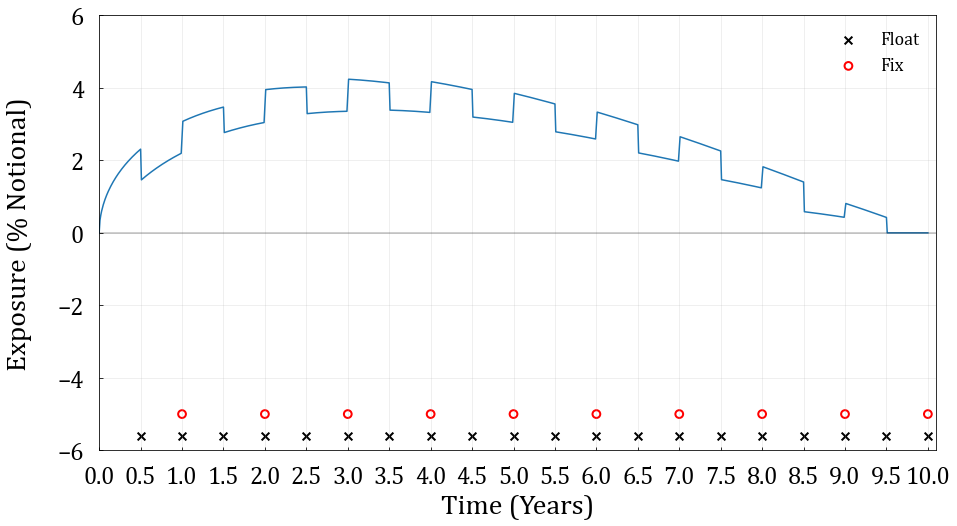

In [8]:

T=np.arange(0,10+0.5,0.5)
S=np.arange(0,11,1)
parSwap = fsolve(lambda x: HW.swap(0, S, T, x), x0=0.02)[0]
xaxis=np.linspace(0,10,1001)

plt.figure(figsize=(16,10))


time, float = HW.create_path(1/100,10, seed=0)
discounting = np.array([HW.marketZCB(t) for t in time])

plt.rc('font',family='Cambria')
float_x = np.arange(0.5,10.5,0.5)
float_y = np.full((len(float_x),), -5.6)
fix_x = np.arange(1,11)
fix_y = np.full(len(fix_x), -5)

fig, ax = plt.subplots()
sns.lineplot(x=xaxis, y=[HW.swaption(t=0,Te=x, S=S,T=T,K=parSwap, payer=True)*100 for x in xaxis])
plt.scatter(x=float_x, y=float_y, label = 'Float', marker = 'x', s = 60, c='black', linewidths=2)
plt.scatter(x=fix_x, y=fix_y, label = 'Fix', marker = 'o', s = 60, facecolors='none', edgecolors='r', linewidths=2)
fig.set_size_inches(15,8)
ax.set_ylim(-6,6)
ax.set_xlim(0,10.1)
ax.set_xlabel('Time (Years)', fontname="Cambria", fontsize = 28)
ax.set_ylabel('Exposure (% Notional)', fontname="Cambria", fontsize = 28)
ax.tick_params(axis='x', direction='in', right = 'True', labelsize = 24, pad = 15)
ax.tick_params(axis='y', direction='in', top = 'True', labelsize = 24, pad = 15)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.axhline(y=0, color='k', alpha = 0.25)
plt.grid(alpha = 0.25)
plt.xticks(np.arange(0, 10.5, 0.5))
plt.legend(frameon = False, fontsize = 18, loc='upper right')

In [ ]:
from scipy.optimize import fsolve
T=np.arange(0,10+0.5,0.5)
S=np.arange(0,11,1)
parSwap = fsolve(lambda x: HW.swap(0, S, T, x), x0=0.02)[0]
xaxis=np.linspace(0,10,1000)

parSwap, HW.swaption(0,1.7,S+1,T+1,parSwap, payer=True)
plt.figure(figsize=(16,10))
sns.lineplot(x=xaxis, y=[HW.swaption(t=0,Te=x, S=S,T=T,K=parSwap, payer=True) for x in xaxis])
# sns.lineplot(x=xaxis, y=[-HW.swaption(t=0,Te=x, S=S,T=T,K=parSwap, payer=False) for x in xaxis])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


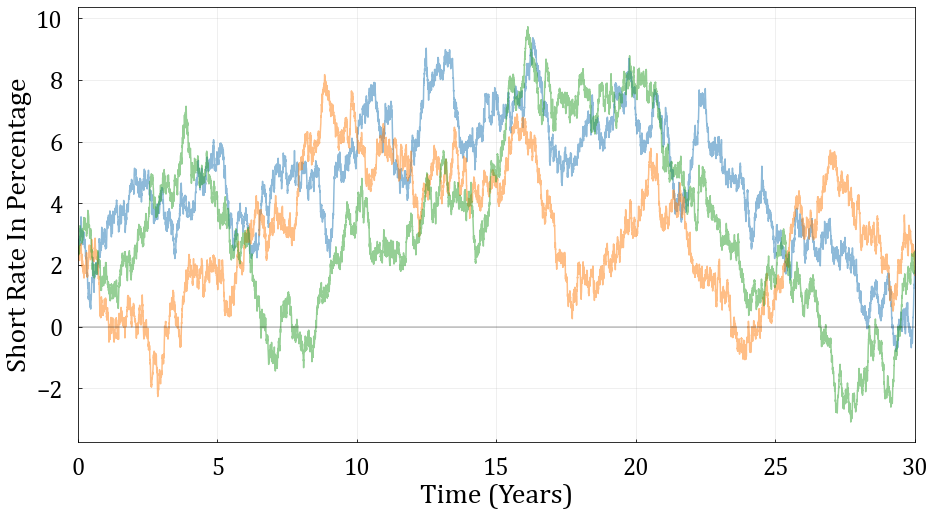

In [8]:
plt.rc('font',family='Cambria')
fig, ax = plt.subplots()
for i in range(3):
    np.random.seed(i)
    time, float = HW.create_path(1/365,30)
    sns.lineplot(x=time, y=float*100, alpha=0.5)
# sns.lineplot(x=time, y=[HW.theta(t)/HW.rev*100 for t in time], color='red', label='θ(t)')   

fig.set_size_inches(15,8)

ax.set_xlabel('Time (Years)', fontname="Cambria", fontsize = 28)
ax.set_ylabel('Short Rate In Percentage', fontname="Cambria", fontsize = 28)
ax.tick_params(axis='x', direction='in', right = 'True', labelsize = 24, pad = 15)
ax.tick_params(axis='y', direction='in', top = 'True', labelsize = 24, pad = 15)
ax.axhline(y=0, color='k', alpha = 0.25)
ax.set_xlim(0,30)
plt.grid(alpha = 0.25)
plt.xticks(np.arange(0, 35, 5))
plt.legend(frameon = False, fontsize = 18, loc='upper right')
plt.savefig('./Graphs/SimPathExample.png', bbox_inches='tight')

In [68]:
#10Y Payer Swap Exposure
from joblib import Parallel, delayed, cpu_count
time, float = HW.create_path(1/100,10, seed=0)
K=fsolve(lambda x: HW.swap(0, S, T, x), x0=0.02)[0]
sims = 100000
def worker(i):
    time, float = HW.create_path(1/100,10, seed=i)
    swap = np.array([HW.swap(x[0], S, T, K=K, initRate=x[1]) for x in np.array([time,float]).T])
    return np.maximum(swap,0), np.minimum(swap,0)

print('Starting parallel processing with {} cores'.format(cpu_count()))
results = Parallel(n_jobs=cpu_count())(delayed(worker)(i) for i in range(sims))
print('Finished parallel processing')
PE = np.zeros(len(time))
NE = np.zeros(len(time))
print('Starting sequential processing')
for i in range(len(results)):
    print(f'Processing {round(i/len(results)),2}%', end='\r')
    PE += results[i][0]
    NE += results[i][1]

Starting parallel processing with 16 cores


KeyboardInterrupt: 

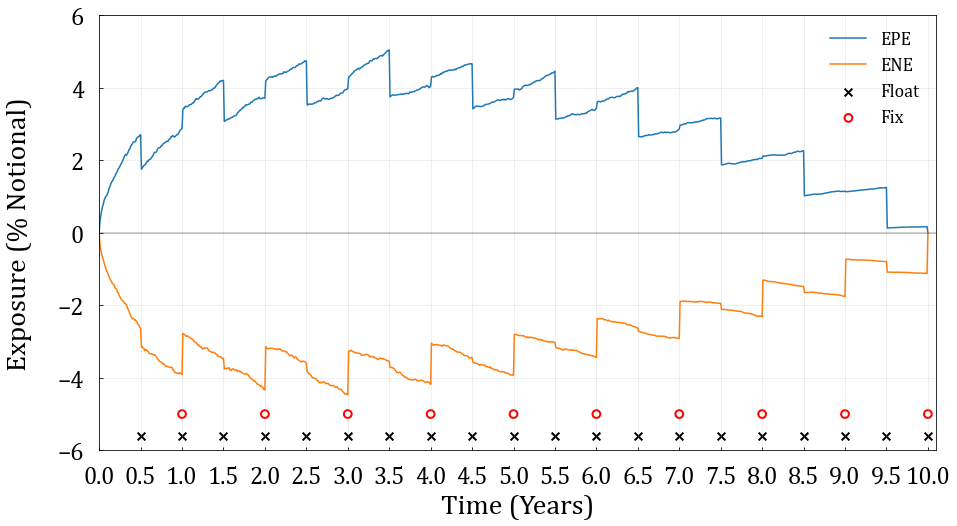

In [ ]:
time, float = HW.create_path(1/100,10, seed=0)
discounting = np.array([HW.marketZCB(t) for t in time])

plt.rc('font',family='Cambria')
float_x = np.arange(0.5,10.5,0.5)
float_y = np.full((len(float_x),), -5.6)
fix_x = np.arange(1,11)
fix_y = np.full(len(fix_x), -5)

fig, ax = plt.subplots()
sns.lineplot(x=time, y=discounting*PE/sims*100, label = 'EPE')
sns.lineplot(x=time, y=discounting*NE/sims*100, label = 'ENE')
plt.scatter(x=float_x, y=float_y, label = 'Float', marker = 'x', s = 60, c='black', linewidths=2)
plt.scatter(x=fix_x, y=fix_y, label = 'Fix', marker = 'o', s = 60, facecolors='none', edgecolors='r', linewidths=2)
fig.set_size_inches(15,8)
ax.set_ylim(-6,6)
ax.set_xlim(0,10.1)
ax.set_xlabel('Time (Years)', fontname="Cambria", fontsize = 28)
ax.set_ylabel('Exposure (% Notional)', fontname="Cambria", fontsize = 28)
ax.tick_params(axis='x', direction='in', right = 'True', labelsize = 24, pad = 15)
ax.tick_params(axis='y', direction='in', top = 'True', labelsize = 24, pad = 15)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.axhline(y=0, color='k', alpha = 0.25)
plt.grid(alpha = 0.25)
plt.xticks(np.arange(0, 10.5, 0.5))
plt.legend(frameon = False, fontsize = 18, loc='upper right')


In [ ]:
#5Y10Y Payer Swaption Exposure
time, float = HW.create_path(1/100,15, seed=0)
from joblib import Parallel, delayed, cpu_count
import sys
K=fsolve(lambda x: HW.swap(0, S+5, T+5, x), x0=0.02)[0]
sims = 100000

def worker(i):
    time, float = HW.create_path(1/100, 15, seed=i)
    swap = np.array([HW.swaption(x[0], Te=5, S=S+5, T=T+5, K=K, initRate=x[1]) for x in np.array([time,float]).T])
    if swap[np.where(time==5)] < 0:
        swap[np.where(time>=5)]=0
    return np.maximum(swap,0), np.minimum(swap,0)

print('Starting parallel processing with {} cores'.format(cpu_count()))
results = Parallel(n_jobs=cpu_count())(delayed(worker)(i) for i in range(sims))
print('Finished parallel processing')
PE = np.zeros(len(time))
NE = np.zeros(len(time))
print('Starting sequential processing')
for i in range(len(results)):
    print(f'Processing {round(i/len(results)),2}%', end='\r')
    PE += results[i][0]
    NE += results[i][1]

Starting parallel processing with 16 cores
Finished parallel processing
Starting sequential processing


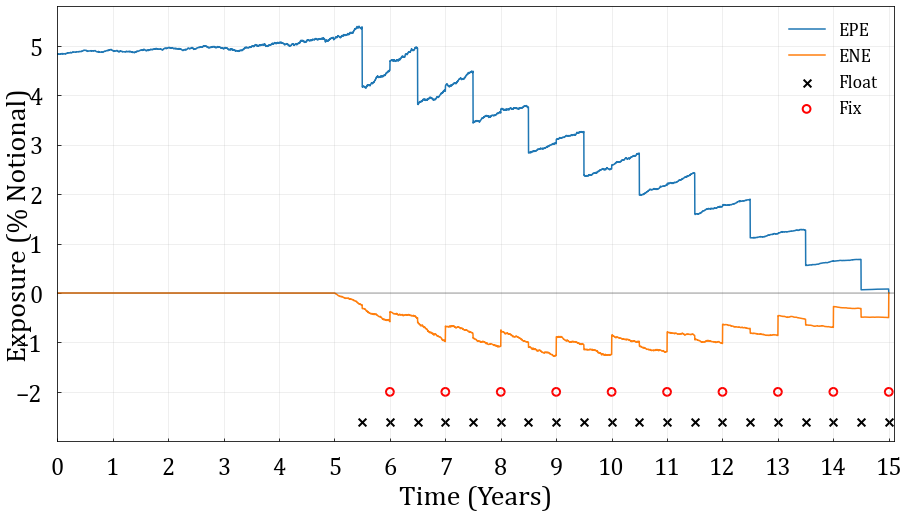

In [ ]:
time, float = HW.create_path(1/100,15, seed=0)
discounting = np.array([HW.marketZCB(t) for t in time])

plt.rc('font',family='Cambria')
float_x = np.arange(5.5,15.5,0.5)
float_y = np.full((len(float_x),), -2.6)
fix_x = np.arange(6,16)
fix_y = np.full(len(fix_x), -2)

fig, ax = plt.subplots()
sns.lineplot(x=time, y=discounting*PE/sims*100, label = 'EPE')
sns.lineplot(x=time, y=discounting*NE/sims*100, label = 'ENE')
plt.scatter(x=float_x, y=float_y, label = 'Float', marker = 'x', s = 60, c='black', linewidths=2)
plt.scatter(x=fix_x, y=fix_y, label = 'Fix', marker = 'o', s = 60, facecolors='none', edgecolors='r', linewidths=2)
fig.set_size_inches(15,8)
# ax.set_ylim(-6,6)time, float = HW.create_path(1/365,10, seed=0)
ax.set_xlim(0,15.1)
ax.set_xlabel('Time (Years)', fontname="Cambria", fontsize = 28)
ax.set_ylabel('Exposure (% Notional)', fontname="Cambria", fontsize = 28)
ax.tick_params(axis='x', direction='in', right = 'True', labelsize = 24, pad = 15)
ax.tick_params(axis='y', direction='in', top = 'True', labelsize = 24, pad = 15)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.03, 0.5)
ax.axhline(y=0, color='k', alpha = 0.25)
plt.grid(alpha = 0.25)
plt.xticks(np.arange(0, 16))
plt.legend(frameon = False, fontsize = 18, loc='upper right')

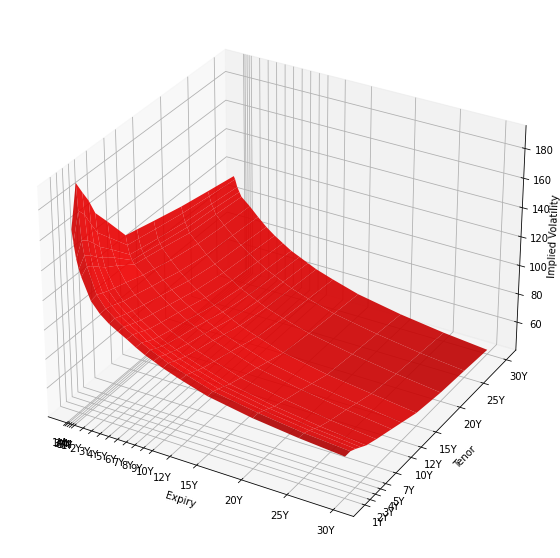

In [32]:
import pandas as pd

file_path   = 'bvolmatrix.xlsx'
sheet       = 'STRADDLE'
sheetf      = 'STRIKE'
sheeti      = 'BVOL'
df          = pd.read_excel(file_path, sheet_name=sheet,header=None)
dff         = pd.read_excel(file_path, sheet_name=sheetf,header=None)
dfi         = pd.read_excel(file_path, sheet_name=sheeti,header=None)
straddlesobs       = pd.DataFrame(df[[x for x in np.arange(4,16)]][3:22])
strikes            = pd.DataFrame(dff[[x for x in np.arange(4,16)]][3:22])
impliedVol         = pd.DataFrame(dfi[[x for x in np.arange(4,16)]][3:22])
straddlesobs.index     = df[1][3:22].values
strikes.index          = dff[1][3:22].values
impliedVol.index       = dfi[1][3:22].values
straddlesobs.index.name='Expiry'
strikes.index.name     ='Expiry'
impliedVol.index.name  ='Expiry' 
straddlesobs.columns   = [int(x) for x in df.iloc[1][4:16].values]
strikes.columns        = [int(x) for x in dff.iloc[1][4:16].values]
impliedVol.columns     = [int(x) for x in dfi.iloc[1][4:16].values]
# straddlesobs
sheeta      = 'ARTICLE'
dfff        = pd.read_excel(file_path, sheet_name=sheeta,header=None)
articleobs  = dfff[[x for x in np.arange(4,17)]][3:17]/10000
articleobs.index = dfff[1][3:17].values
articleobs.index.name = 'Expiry'
articleobs.columns = [int(x) for x in dfff.iloc[1][4:17].values]

# straddlesobs=straddlesobs.iloc[4::,2::]
# strikes = strikes.iloc[4::,2::]
# impliedVol = impliedVol.iloc[4::,2::]

def monthoryear(x):
    if x<12:
        return f'{int(x)}M'
    else:
        return f'{int(x/12)}Y'
    

# X,Y = np.meshgrid(straddlesobs.columns/12, straddlesobs.index/12)
# fig = plt.figure(figsize=(16,16))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(Y,X,straddlesobs.values)
# ax.set_xlabel('Expiry')
# ax.set_xticks((straddlesobs.index/12))
# ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
# ax.set_ylabel('Tenor')
# ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])
# ax.set_yticks(straddlesobs.columns/12)
# ax.invert_xaxis()
# plt.show()

# fig = plt.figure(figsize=(8,8))
# X,Y = np.meshgrid(impliedVol.columns/12, impliedVol.index/12)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(Y,X,impliedVol.values, alpha=0.9, color='red')

# ax.set_xlabel('Expiry')
# ax.set_xticks((straddlesobs.index/12))
# ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
# ax.set_ylabel('Tenor')
# ax.set_yticks(straddlesobs.columns/12)
# ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])
# ax.invert_xaxis()
# plt.show()

fig = plt.figure(figsize=(10,10))
X,Y = np.meshgrid(impliedVol.columns/12, impliedVol.index/12)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,impliedVol.values, alpha=0.9, color='red')
ax.set_xlabel('Expiry')
ax.set_xticks((straddlesobs.index/12))
ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
ax.set_ylabel('Tenor')
ax.set_zlabel('Implied Volatility')
ax.zaxis.labelpad=-0.7
ax.set_yticks(straddlesobs.columns/12)
ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])

plt.show()

In [15]:
from scipy.optimize import minimize, basinhopping, fsolve
def HullWhiteOptimizer(reversion,volatility, observedP, observedK):
    if volatility <= 0:
        print('Volatility is negative')
        return 100000, 100000
    straddleModel = observedP.copy()
    optHW = HullWhite(initial=0.02748672, 
                      reversion=reversion, 
                      Gamma=1000, 
                      b = np.array([1.879892, 0.579211, 	3.993992, 1.445091]),
                      tau  = np.array([ 16.633491, 	0.319680]),
                      volatility=volatility)
    for expiry in observedP.index:
        # Expiry first
        # Getting the right expiry and converting to years
        
        for tenor in observedP.columns:
            # Creating tenor legs
            T = np.arange(expiry/12, expiry/12+tenor/12+0.5, 0.5)
            S = np.arange(expiry/12, expiry/12+tenor/12+1)
            # Finding the ATM fixed rate
            K = observedK[tenor].loc[expiry]/100
            # K = fsolve(lambda x: optHW.swap(0, S, T, x), x0=MarketATM)[0]

            #Calculating the payer and receiver swpt price
            p = optHW.swaption(0,Te=expiry/12, S=S,T=T, K=K, payer=True)
            r = optHW.swaption(0,Te=expiry/12, S=S, T=T, K=K, payer=False)
            
            #Normalizing w.r.t. to the A(t,S) function (2.10) everythin you wanna know...
            A = np.array([optHW.marketZCB(Si) for Si in S[1::]]).sum()

            straddleModel[tenor].loc[expiry] = (p+r)/A
            # if (p+r)*10000<0:
            # print(p,r,expiry,tenor,reversion,volatility)
            

    error = ((straddleModel/observedP-1)**2).sum().sum()
    # print(f'{error}', end='                                                         \r')
    return error,straddleModel

In [29]:
Nfeval = 0
def callback(xk):
    global Nfeval
    print(f'Eval: {Nfeval}, x={(xk[0],xk[1])}, func: {HullWhiteOptimizer(xk[0], xk[1], observedP=straddlesobs, observedK=strikes)[0]}')
    Nfeval += 1
    return True
# callback([0.027832947, 0.11874695, 0.019677])

result = minimize(
    fun = lambda x: HullWhiteOptimizer(reversion=x[0], volatility=x[1], observedP=straddlesobs, observedK=strikes)[0],
    x0  = np.array([2,0.002]),
    # bounds = [(0.1,3),(1e-15,0.5)],
    # method='nelder-mead',
    # tol = 1e-10,
    callback=callback
)

Eval: 0, x=(2.0014902370305365, 0.09610501863648109), func: 55.320420896306274


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S)/(self.ZCB(t,T)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:155: RuntimeWarning: invalid value encountered in double_scalars
  h      = np.log(self.ZCB(t,S)/(self.ZCB(t,T)*X))/sigmap+sigmap/2


Eval: 1, x=(1.9972398002325908, 0.09863235072054549), func: 55.2857072410368
Volatility is negative
Volatility is negative
Volatility is negative
Volatility is negative
Volatility is negative
Volatility is negative
Eval: 2, x=(0.204534920869351, 0.024816262301034966), func: 24.189162431328285
Volatility is negative
Volatility is negative
Volatility is negative
Eval: 3, x=(0.20342138202380275, 0.024763107406818596), func: 24.183006611234493
Eval: 4, x=(0.190240099730105, 0.023456747665359115), func: 23.181614004426596
Eval: 5, x=(0.16214376515933826, 0.020660520370664126), func: 21.50037535342248
Eval: 6, x=(0.12154326847412589, 0.016097291024024248), func: 20.939710318974086
Eval: 7, x=(0.14668835998049853, 0.018296518455637473), func: 20.68738952667211
Eval: 8, x=(0.14003991727045434, 0.017863558128342893), func: 20.66581011641599
Eval: 9, x=(0.139481817939527, 0.017785473914601273), func: 20.66526924952284
Eval: 10, x=(0.1394888941460445, 0.017793570126501262), func: 20.6652496824133

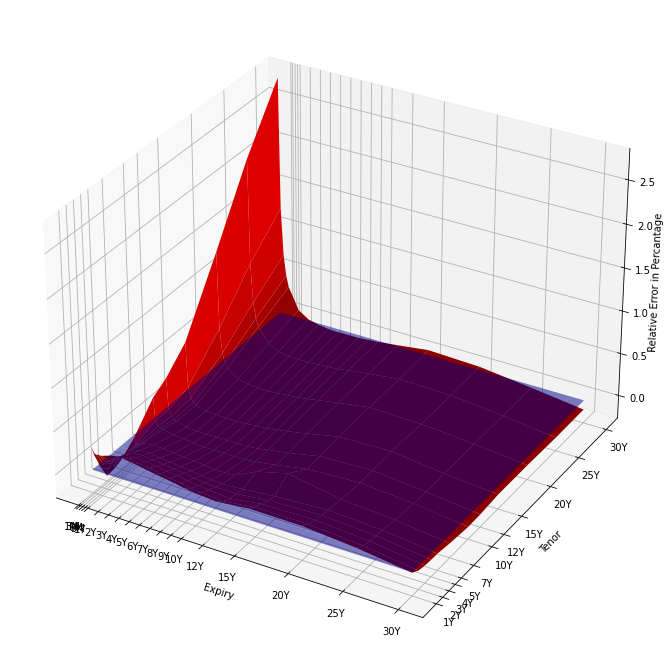

In [44]:
rev=0.13949636660880768#result.x[0]
vol=0.017793899652989272#result.x[1]
fittedHW = (HullWhiteOptimizer(reversion=rev ,volatility=vol, observedP=straddlesobs, observedK=strikes)[1]/straddlesobs-1)
X,Y = np.meshgrid(fittedHW.columns/12, fittedHW.index/12)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,np.zeros(19*12).reshape(fittedHW.values.shape), color='blue', alpha=0.5)
ax.plot_surface(Y,X,fittedHW.values, color = 'red')
ax.set_xlabel('Expiry')
ax.set_xticks((straddlesobs.index/12))
ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
ax.set_ylabel('Tenor')
ax.set_yticks(straddlesobs.columns/12)
ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])
ax.zaxis.labelpad=-0.7
ax.set_zlabel('Relative Error in Percantage')
plt.show()
# HullWhiteOptimizer(reversion=rev ,volatility=vol, observedP=straddlesobs, observedK=strikes)[0]

In [57]:
HW.ZCB(0,10),HW.marketZCB(10)

(0.7280490594970028, 0.7280490594970028)

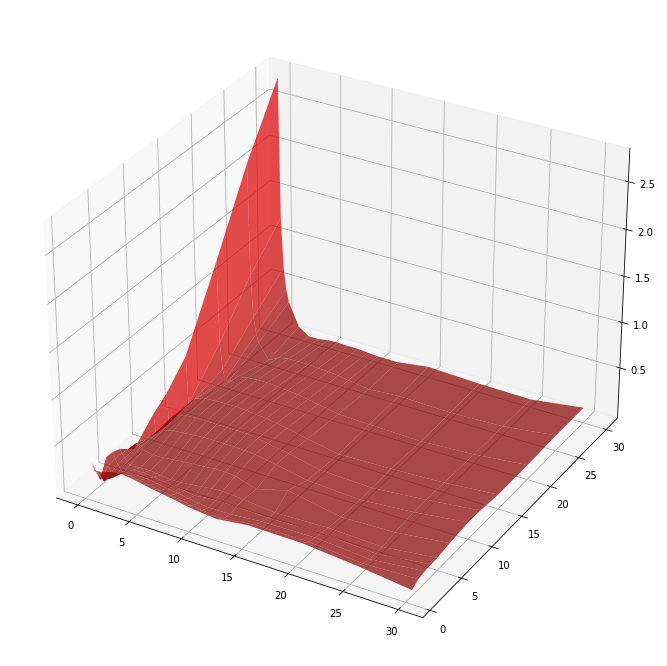

In [51]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111, projection='3d')

X,Y = np.meshgrid(straddlesobs.columns/12, straddlesobs.index/12)
ax1.plot_surface(Y,X,straddlesobs.values, alpha=0.7, color='blue')

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,fittedHW.values, alpha=0.7, color='red')



ax1.set_xlabel('Expiry')
ax1.set_xticks((straddlesobs.index/12)[::-1])
ax1.set_ylabel('Tenor')
ax1.set_yticks(straddlesobs.columns/12)
ax1.invert_xaxis()

# ax1 = fig.add_subplot(111, projection='3d')


plt.show()

<AxesSubplot: >

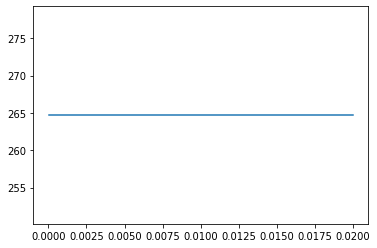

In [99]:
sns.lineplot(x=np.linspace(0.00001,0.02,10), y=[HullWhiteOptimizer(reversion=0.88 ,volatility=vol, observedP=straddlesobs, observedK=strikes)[0] for vol in np.linspace(0.00001,0.02,10)])